In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is not available, using CPU instead


In [3]:
df = pd.read_csv(r"C:\Users\smbm2\projects\TrafficFlowForecasting\warins_experiments\data\Scenario B\TimeBasedFeatures-Dataset-15s-AllinOne.csv") # personal
# df = pd.read_csv(r"C:\python\research\csv_datasets\Scenario B\TimeBasedFeatures-Dataset-15s-AllinOne.csv") # for IR

df.head()

,Unnamed: 0,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,...,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,CHAT
1,1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,...,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,CHAT
2,2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,...,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,CHAT
3,3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,...,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,CHAT
4,4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,...,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,CHAT


In [4]:
le = LabelEncoder()
df['class1'] = le.fit_transform(df['class1'])

In [5]:
class vpnDataset(Dataset):
    def __init__(self, df, target = 'class1'):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.int64).values

        self.scalar = StandardScaler()
        self.x = self.scalar.fit_transform(df.drop(columns=[target])).astype(np.float32)

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
vpn_dataset = vpnDataset(df)

In [6]:
train_size = int(0.7*len(vpn_dataset))
print(train_size)
test_size = len(vpn_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(vpn_dataset, [train_size, test_size])
print(len(train_dataset), len(test_dataset))

13130
13130 5628


In [7]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

In [49]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, key_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # print('energy shape ', energy.shape)

        # if mask is not None:
        #     energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention[:,:,-1,:] #taking only the attention of the last embedding
        avg_attention = attention.mean(dim=0)  # Average across batches
        avg_attention = avg_attention.mean(dim=1).squeeze(dim=0)  # Average across heads -> (#key_embeddings)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        # print('values shape', values.shape)
        # print('output shape', out.shape)
        out = self.fc_out(out)


        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention

class Encoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 encoder_dropout
    ):
        super(Encoder, self).__init__()
        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=encoder_dropout,
                    forward_expansion=forward_expansion
                )
                for _ in range(num_layers)
            ]
        )
        self.avg_attention = None

    def forward(self, x):
        for layer in self.layers:
            #running embeddings through transformer block
            #keys, values, and query are all the same initially (x)
            x, self.avg_attention = layer(x, x, x)
     
        # print("encoder output", x.shape)
        return x #same dimensions as going in 


In [50]:
class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_features, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for x in range(n_features)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for x in range(n_features)])

        #CLS Token or Classification embedding
        self.classification_embedding = nn.Embedding(1, embed_size)

    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.embeddings):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            # print("goin out shape:", goin_out.shape)
            embeddings.append(goin_out)

        class_embed = self.classification_embedding(torch.tensor([0])) #use index 0 for the classification embedding
        # print("class_embed shape:", class_embed.shape)
        class_embed = class_embed.repeat(x.size(0), 1) # -> (batch_size, embed_size)
        # print("class_embed shape after repeat:", class_embed.shape)
        embeddings.append(class_embed)
        # print("class_embed shape after unsqueeze:", class_embed.shape)
        x = torch.stack(embeddings, dim=1)

        # print("New embeddings", x.shape)
        return x

In [38]:
test = Embeddings(sigma=2, embed_size=20, input_size=1, embedding_dropout=0, n_features=23, rff_on=False)
for (inputs, targets) in train_dataloader:
        
        inputs, targets = inputs.to(device_in_use), targets.to(device_in_use)
        # print(batch_idx, inputs, targets)
        pred = test(inputs)
        print(pred)

goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
goin out shape: torch.Size([256, 20])
class_embed shape: torch.Size([1, 20])
class_embed shape after repeat: torch.Size([256, 20])
class_embed shape after unsqueeze

In [10]:
class classificationHead(nn.Module):
    def __init__(self, n_features, embed_size, dropout, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.n_features = n_features*embed_size
        self.lin1 = nn.Linear(self.n_features, self.n_features)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(self.n_features, num_target_classes)
        
        self.relu = nn.ReLU()
        # self.softmax = nn.Softmax()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin2.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.n_features))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        # x = self.softmax(x)
        # print(x.shape)
  
        return x

In [11]:
class LSTM_aggregation(nn.Module):
    def __init__(self, input_size, num_layers, batch_sz):
        super(LSTM_aggregation, self).__init__()
        
        self.embed_size = input_size
        self.num_layers = num_layers
        self.batch_sz = batch_sz
        self.aggregation = nn.LSTM(
                input_size = self.embed_size,
                hidden_size = self.embed_size,
                num_layers = self.num_layers,
                batch_first = True
            )
    def forward(self, x):
        x, _ = self.aggregation(x)
        
        return x

In [51]:
class vpnClassifier(nn.Module):
    def __init__(self, 
                 rff_on = True,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_features=23,
                 num_layers=2,
                 heads=4,
                 forward_expansion=4,
                 encoder_dropout=0,
                 aggregation_on = True,
                 lstm_layers=1,
                 batch_sz = 256,
                 num_target_classes = 7,
                 classification_dropout = 0
                 ):
        super(vpnClassifier, self).__init__()
        self.aggregation_on = aggregation_on

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, embedding_dropout=embedding_dropout, n_features=n_features)
        self.encoder = Encoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, encoder_dropout=encoder_dropout)
        if self.aggregation_on:
            self.aggregation = LSTM_aggregation(input_size=embed_size, num_layers=lstm_layers, batch_sz=batch_sz)
        self.classifying_head = classificationHead(n_features=1, embed_size=embed_size, dropout=classification_dropout, num_target_classes=num_target_classes)
        
    def forward(self, x):
        x = self.embeddings(x)

        x = self.encoder(x)

        #only taking the last embedding
        x = x[:, -1, :]

        if self.aggregation_on:
            x = self.aggregation(x)
            
        x = self.classifying_head(x)
        return x


In [41]:
def train(dataloader, model, loss_fn, optimizer, device_in_use):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for (inputs, targets) in dataloader:
        
        inputs, targets = inputs.to(device_in_use), targets.to(device_in_use)
        # print(batch_idx, inputs, targets)
        pred = model(inputs)
        # print(pred)
        # print(targets)
        # print(pred.squeeze(0))
        loss = loss_fn(pred, targets)
        total_loss+= loss.item()

        # Calculate accuracy
        y_pred_softmax = torch.log_softmax(pred, dim =1)
        _, y_pred_labels = torch.max(y_pred_softmax, dim=1)
        total_correct += (y_pred_labels == targets).sum().item()
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy
    

def test(dataloader, model, loss_fn, device_in_use):
  model.eval()
  tot = 0
  total_correct = 0
  total_samples = 0
  with torch.no_grad():
    for (inputs, targets) in dataloader:
      inputs, targets = inputs.to(device_in_use), targets.to(device_in_use)
      #compute prediction error
      pred = model(inputs)
      test_loss = loss_fn(pred, targets)
      tot += test_loss

      # Calculate accuracy
      y_pred_softmax = torch.log_softmax(pred, dim =1)
      _, y_pred_labels = torch.max(y_pred_softmax, dim=1)
      total_correct += (y_pred_labels == targets).sum().item()
      total_samples += targets.size(0)

  avg = tot/len(dataloader)
  accuracy = total_correct / total_samples

  return avg, accuracy

Epoch 1/15, Train Loss: 1.7123, Test Loss: 1.5486, Train Accuracy: 0.3757, Test Accuracy: 0.4527
Epoch 2/15, Train Loss: 1.2871, Test Loss: 1.1467, Train Accuracy: 0.5794, Test Accuracy: 0.6443
Epoch 3/15, Train Loss: 0.9995, Test Loss: 0.9128, Train Accuracy: 0.6726, Test Accuracy: 0.6498
Epoch 4/15, Train Loss: 0.6838, Test Loss: 0.4988, Train Accuracy: 0.7440, Test Accuracy: 0.8154
Epoch 5/15, Train Loss: 0.4200, Test Loss: 0.3594, Train Accuracy: 0.8627, Test Accuracy: 0.8531
Epoch 6/15, Train Loss: 0.3066, Test Loss: 0.2728, Train Accuracy: 0.9153, Test Accuracy: 0.9218
Epoch 7/15, Train Loss: 0.2482, Test Loss: 0.2444, Train Accuracy: 0.9298, Test Accuracy: 0.9291
Epoch 8/15, Train Loss: 0.2115, Test Loss: 0.2144, Train Accuracy: 0.9402, Test Accuracy: 0.9287
Epoch 9/15, Train Loss: 0.1777, Test Loss: 0.1624, Train Accuracy: 0.9466, Test Accuracy: 0.9558
Epoch 10/15, Train Loss: 0.1521, Test Loss: 0.1373, Train Accuracy: 0.9545, Test Accuracy: 0.9693
Epoch 11/15, Train Loss: 0.13

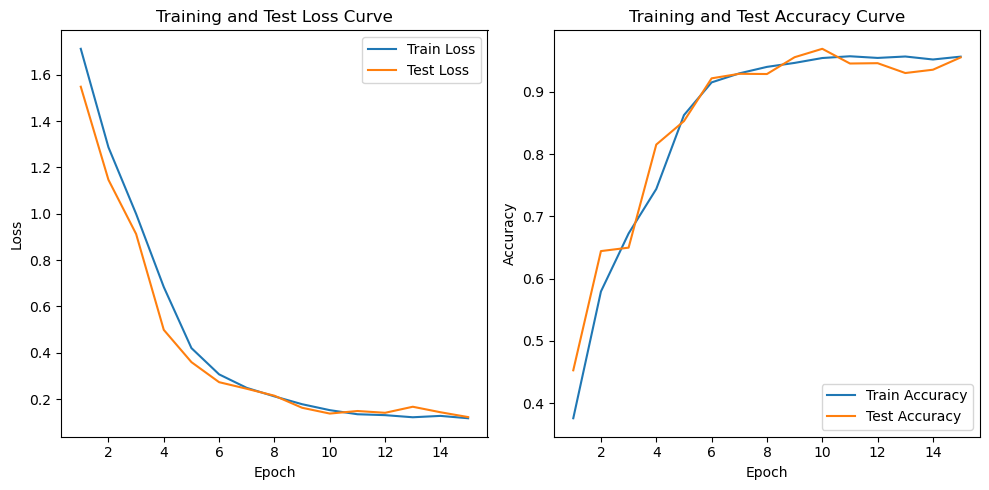

Best accuracy: 0.9692608386638237


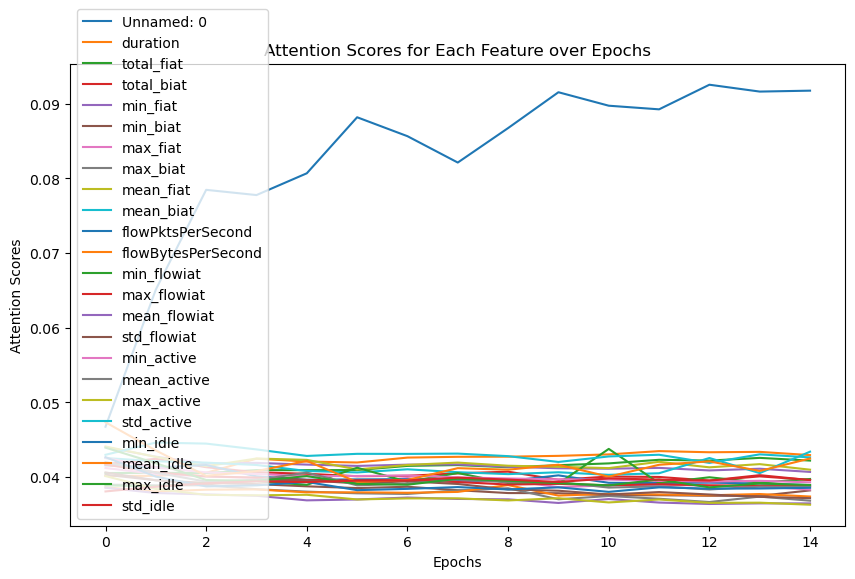

1. Unnamed: 0: 0.09173449873924255
2. mean_biat: 0.04340145364403725
3. duration: 0.04294256493449211
4. std_active: 0.042635172605514526
5. mean_idle: 0.042488351464271545
6. total_fiat: 0.042209308594465256
7. mean_fiat: 0.04098944738507271
8. min_fiat: 0.040690165013074875
9. min_flowiat: 0.03974286839365959
10. std_idle: 0.03962250426411629


In [54]:
#No RFF, No aggregation, 1 encoder layer, no regularization. VERY BASIC
model = vpnClassifier(rff_on=False, num_layers=1, aggregation_on=False, heads=1).to(device_in_use)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.0001, momentum=0.9)

epochs = 15
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
all_attention_scores = []
for t in range(epochs):
  train_loss, train_accuracy= train(train_dataloader, model, loss_fn, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
  

  total_attention = model.encoder.avg_attention
  all_attention_scores.append(total_attention.tolist())
  model.encoder.avg_attention = None


# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l.cpu().numpy() for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

# Plot attention scores for each feature over epochs

# all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
all_attention_scores = torch.tensor(all_attention_scores)
plt.figure(figsize=(10, 6))



for feature_idx in range(all_attention_scores.shape[1]):
    plt.plot(all_attention_scores[:, feature_idx], label=df.drop("class1", axis=1).columns[feature_idx])

plt.xlabel('Epochs')
plt.ylabel('Attention Scores')
plt.title('Attention Scores for Each Feature over Epochs')
plt.legend(loc = 'lower left')
plt.show()

last_epoch_attention_scores = all_attention_scores[-1]
top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# Display the top 10 attention scores and the corresponding feature
for i in range(10):
    print(f"{i+1}. {df.drop('class1', axis=1).columns[int(top_indices[i])]}: {top_scores[i]}")

Epoch 1/50, Train Loss: 1.5918, Test Loss: 1.2591, Train Accuracy: 0.3992, Test Accuracy: 0.4858
Epoch 2/50, Train Loss: 1.1239, Test Loss: 1.0533, Train Accuracy: 0.5367, Test Accuracy: 0.5707
Epoch 3/50, Train Loss: 0.9553, Test Loss: 0.9066, Train Accuracy: 0.6788, Test Accuracy: 0.7427
Epoch 4/50, Train Loss: 0.8114, Test Loss: 0.7696, Train Accuracy: 0.7446, Test Accuracy: 0.7408
Epoch 5/50, Train Loss: 0.6618, Test Loss: 0.6328, Train Accuracy: 0.7880, Test Accuracy: 0.7797
Epoch 6/50, Train Loss: 0.5294, Test Loss: 0.5135, Train Accuracy: 0.8317, Test Accuracy: 0.8054
Epoch 7/50, Train Loss: 0.4192, Test Loss: 0.3816, Train Accuracy: 0.8554, Test Accuracy: 0.8630
Epoch 8/50, Train Loss: 0.3295, Test Loss: 0.3376, Train Accuracy: 0.8831, Test Accuracy: 0.8735
Epoch 9/50, Train Loss: 0.2598, Test Loss: 0.2578, Train Accuracy: 0.9168, Test Accuracy: 0.9057
Epoch 10/50, Train Loss: 0.2189, Test Loss: 0.2126, Train Accuracy: 0.9339, Test Accuracy: 0.9350
Epoch 11/50, Train Loss: 0.17

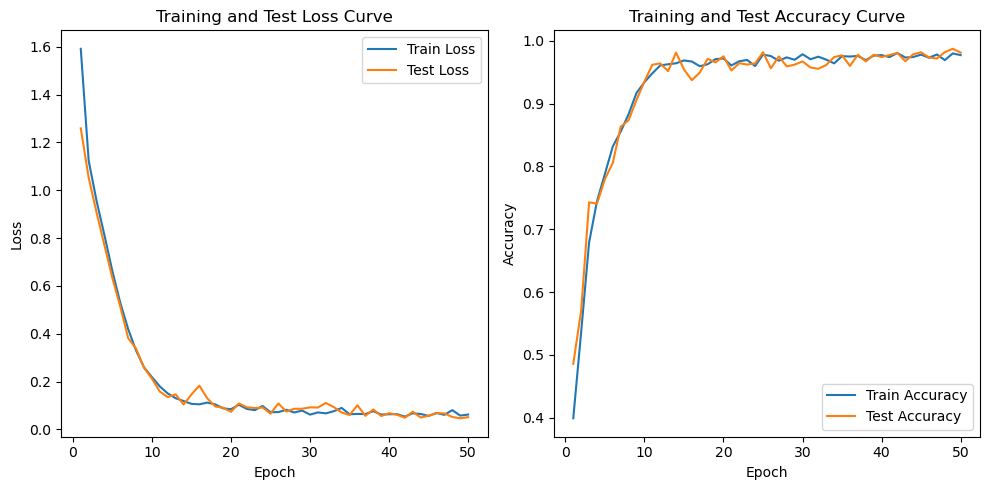

Best accuracy: 0.9870291400142146


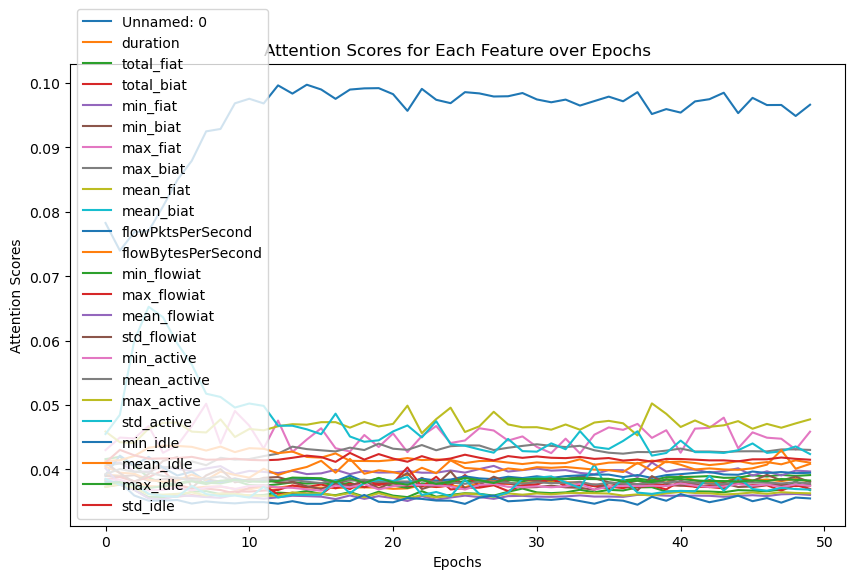

1. Unnamed: 0: 0.09662586450576782
2. mean_fiat: 0.04775294288992882
3. max_fiat: 0.04583768919110298
4. max_biat: 0.04300370439887047
5. mean_biat: 0.042360126972198486
6. std_idle: 0.04148310050368309
7. mean_idle: 0.04102285951375961
8. flowBytesPerSecond: 0.04082918539643288
9. min_fiat: 0.03966275230050087
10. flowPktsPerSecond: 0.03945395350456238


In [55]:
#No RFF, No aggregation, 1 encoder layer, no regularization. VERY BASIC
model = vpnClassifier(rff_on=False, num_layers=1, aggregation_on=False, heads=1).to(device_in_use)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.0001, momentum=0.9)

epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
all_attention_scores = []
for t in range(epochs):
  train_loss, train_accuracy= train(train_dataloader, model, loss_fn, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
  

  total_attention = model.encoder.avg_attention
  all_attention_scores.append(total_attention.tolist())
  model.encoder.avg_attention = None


# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l.cpu().numpy() for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

# Plot attention scores for each feature over epochs

# all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
all_attention_scores = torch.tensor(all_attention_scores)
plt.figure(figsize=(10, 6))



for feature_idx in range(all_attention_scores.shape[1]):
    plt.plot(all_attention_scores[:, feature_idx], label=df.drop("class1", axis=1).columns[feature_idx])

plt.xlabel('Epochs')
plt.ylabel('Attention Scores')
plt.title('Attention Scores for Each Feature over Epochs')
plt.legend(loc = 'lower left')
plt.show()

last_epoch_attention_scores = all_attention_scores[-1]
top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# Display the top 10 attention scores and the corresponding feature
for i in range(10):
    print(f"{i+1}. {df.drop('class1', axis=1).columns[int(top_indices[i])]}: {top_scores[i]}")

In [56]:
#comparing with the feature importance ranking of sklearn's random forest

X = df.drop('class1', axis=1)
y = df['class1']

X_train, X_test, y_train, y_test =train_test_split(X, y, train_size=0.7, random_state=1)

rf = RandomForestClassifier(class_weight='balanced', max_depth=30,
                       max_features='log2', min_samples_leaf=2,
                       min_samples_split=5)

rf.fit(X_train, y_train)

yhat = rf.predict(X_test)

acc = accuracy_score(y_test, yhat)

print('accuracy:', acc)


best_features = rf.feature_importances_

# Get indices of top 10 features
top_indices = best_features.argsort()[-10:][::-1]

# Get corresponding feature names
feature_names = df.columns

# Display the top 10 features and their importances
for i, idx in enumerate(top_indices):
    print(f"{i+1}. {feature_names[idx]}: Importance {best_features[idx]}")

accuracy: 0.9689054726368159
1. Unnamed: 0: Importance 0.29198153394547455
2. flowBytesPerSecond: Importance 0.07367699577520842
3. duration: Importance 0.06948409043902563
4. mean_fiat: Importance 0.05056475428705272
5. min_flowiat: Importance 0.050039085665874596
6. total_biat: Importance 0.042758617616109135
7. max_biat: Importance 0.041681043426925524
8. total_fiat: Importance 0.04150198025574215
9. mean_biat: Importance 0.03906074149971854
10. flowPktsPerSecond: Importance 0.03847191999516977
